# Importing Libraries


In [2]:
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression,OrthogonalMatchingPursuit, OrthogonalMatchingPursuit,  Lasso, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from tensorflow.keras import layers
from tensorflow import keras
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor



import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline

# Loading the data

In [9]:
file_path = "Sensor_Data.xlsx"

dfs = []

with pd.ExcelFile(file_path) as xlsx:
    for sheet_name in xlsx.sheet_names:
        df = pd.read_excel(xlsx, sheet_name)
        dfs.append(df)

combined_df = pd.concat(dfs, ignore_index=True)

df = combined_df.copy()
df["Irradiance(W/m2)"] = df["Light Intensity(lumens)"]*0.079
df

,Timestamp,Temperature(Â°C),Light Intensity(lumens),Voltage(Volts)*,Current(Amps),Power(Watts),Irradiance(W/m2)
0,23 Feb 2023 10:07:38 Thu,21.400000,2934,12.321610,0.647139,167.449618,231.786
1,23 Feb 2023 10:07:48 Thu,23.500000,2933,12.309524,0.663877,171.612194,231.707
2,23 Feb 2023 10:07:59 Thu,23.500000,2931,12.313553,0.666773,172.417145,231.549
3,23 Feb 2023 10:08:09 Thu,23.600000,2928,12.297436,0.659287,170.258300,231.312
4,23 Feb 2023 10:08:20 Thu,23.700001,2935,12.289377,0.664926,171.602024,231.865
...,...,...,...,...,...,...,...
24343,22 Mar 2023 16:59:11 Wed,11.100000,1738,1.978388,0.206938,8.597497,137.302
24344,22 Mar 2023 16:59:22 Wed,11.100000,1738,1.881685,0.207006,8.179903,137.302
24345,22 Mar 2023 16:59:32 Wed,11.100000,1735,1.809157,0.202404,7.689811,137.065
24346,22 Mar 2023 16:59:43 Wed,11.200000,1728,1.740659,0.196925,7.198356,136.512


In [4]:
df.corr()

,Temperature(Â°C),Light Intensity(lumens),Voltage(Volts)*,Current(Amps),Power(Watts),Irradiance(W/m2)
Temperature(Â°C),1.000000,0.713119,0.535192,0.550783,0.583471,0.713119
Light Intensity(lumens),0.713119,1.000000,0.868062,0.846748,0.845102,1.000000
Voltage(Volts)*,0.535192,0.868062,1.000000,0.927730,0.969629,0.868062
Current(Amps),0.550783,0.846748,0.927730,1.000000,0.951877,0.846748
Power(Watts),0.583471,0.845102,0.969629,0.951877,1.000000,0.845102
Irradiance(W/m2),0.713119,1.000000,0.868062,0.846748,0.845102,1.000000


In [5]:
results = pd.DataFrame(columns=["Model_name", "RMSE"])

# Radial basis Neural Network

In [7]:


X = df[['Temperature(Â°C)', "Irradiance(W/m2)"]].values
y = df["Power(Watts)"].values

scaler_X =  MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

class RBFNet(object):
    def __init__(self, input_dim, hidden_dim, output_dim, sigma=1.0):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.sigma = sigma
        self.centers = None
        self.weights = None
        
    def _gaussian(self, x, center):
        return np.exp(-self.sigma*np.linalg.norm(x-center)**2)
    
    def _design_matrix(self, X):
        dist = cdist(X, self.centers)
        return np.array([self._gaussian(X[i], self.centers[j]) for i in range(len(X)) for j in range(len(self.centers))]).reshape((len(X), len(self.centers)))
    
    def fit(self, X, y):
        from sklearn.cluster import KMeans
        kmeans = KMeans(n_clusters=self.hidden_dim, random_state=0).fit(X)
        self.centers = kmeans.cluster_centers_
        phi = self._design_matrix(X)
        self.weights = np.linalg.lstsq(phi, y, rcond=None)[0]
        
    def predict(self, X):
        phi = self._design_matrix(X)
        y_pred = np.dot(phi, self.weights)
        return y_pred
    
    def summary(self):
        print("RBFNet Model Summary")
        print("--------------------")
        print(f"Input Dimension: {self.input_dim}")
        print(f"Hidden Dimension: {self.hidden_dim}")
        print(f"Output Dimension: {self.output_dim}")
        print(f"Sigma: {self.sigma}")

input_dim = 2
hidden_dim = 21
output_dim = 1
sigma = 0.2

rbfnet = RBFNet(input_dim, hidden_dim, output_dim, sigma)


rbfnet.fit(X_train, y_train)


y_pred = rbfnet.predict(X_test)

rbfnet.summary()

y_pred = rbfnet.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred)

y_train_pred = rbfnet.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred)

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')

RBFNet Model Summary
--------------------
Input Dimension: 2
Hidden Dimension: 21
Output Dimension: 1
Sigma: 0.2
Test Root Mean Squared Error: 19.1184142805


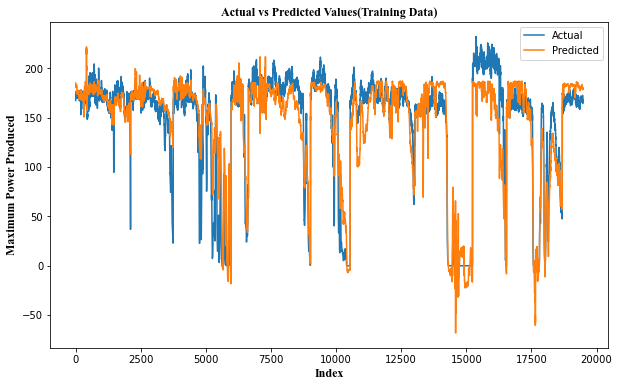

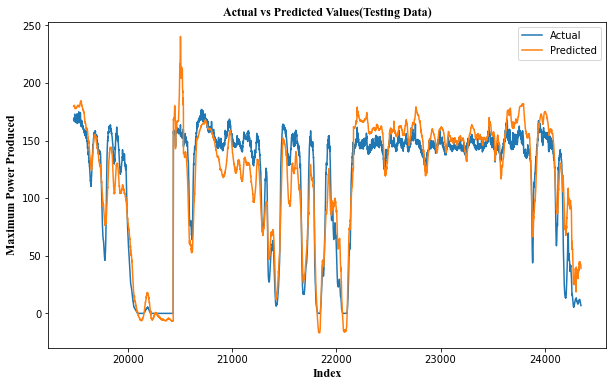

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("Index", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("Index", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()


In [38]:
results = results.append({"Model_name":"Radial Basis Function Neural Network","RMSE": rmse_1}, ignore_index = True)
results

,Model_name,RMSE
0,Radial Basis Function Neural Network,20.728428


# LSTM

In [8]:
model = tf.keras.models.load_model('model_lstm')

In [58]:
train_size = int(len(df) * 0.8)
train_data = df[:int(0.8 * len(df))].copy()
test_data = df[int(0.8 * len(df)):].copy()

scaler = MinMaxScaler()
train_data[['Temperature(Â°C)', "Irradiance(W/m2)", 'Power(Watts)']] = scaler.fit_transform(train_data[['Temperature(Â°C)', "Irradiance(W/m2)", 'Power(Watts)']])
train_data = train_data[['Temperature(Â°C)', "Irradiance(W/m2)", 'Power(Watts)']].copy()
test_data[['Temperature(Â°C)', "Irradiance(W/m2)", 'Power(Watts)']] = scaler.transform(test_data[['Temperature(Â°C)', "Irradiance(W/m2)", 'Power(Watts)']])
test_data = test_data[['Temperature(Â°C)', "Irradiance(W/m2)", 'Power(Watts)']].copy()

time_steps = 50

def create_sequences(dated_data, time_steps):
    X = []
    y = []
    for i in range(len(dated_data) - time_steps):        
        X.append(dated_data.iloc[i:i + time_steps, :2].values)
        y.append(dated_data.iloc[i + time_steps, 2])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data, time_steps)
X_test, y_test = create_sequences(test_data, time_steps)

X_train = X_train.reshape(-1, time_steps, 2)
X_test = X_test.reshape(-1, time_steps, 2)



model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mse', optimizer=Adam(lr=0.001))
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test))

Epoch 1/50
608/608 [==============================] - 58s 86ms/step - loss: 0.0284 - val_loss: 0.0157
Epoch 2/50
608/608 [==============================] - 50s 81ms/step - loss: 0.0189 - val_loss: 0.0245
Epoch 3/50
608/608 [==============================] - 45s 73ms/step - loss: 0.0144 - val_loss: 0.0208
Epoch 4/50
608/608 [==============================] - 51s 84ms/step - loss: 0.0116 - val_loss: 0.0253
Epoch 5/50
608/608 [==============================] - 46s 76ms/step - loss: 0.0103 - val_loss: 0.0302
Epoch 6/50
608/608 [==============================] - 47s 77ms/step - loss: 0.0096 - val_loss: 0.0172
Epoch 7/50
608/608 [==============================] - 49s 80ms/step - loss: 0.0089 - val_loss: 0.0294
Epoch 8/50
608/608 [==============================] - 47s 77ms/step - loss: 0.0085 - val_loss: 0.0359
Epoch 9/50
608/608 [==============================] - 47s 78ms/step - loss: 0.0081 - val_loss: 0.0269
Epoch 10/50
608/608 [==============================] - 47s 77ms/step - loss: 0.007

In [59]:
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

y_pred = scaler.inverse_transform(np.hstack((X_test[:, -1, :2], y_pred.reshape(-1, 1))))
y_pred = y_pred[:, -1]

y_test_is = scaler.inverse_transform(np.hstack((X_test[:, -1, :2], y_test.reshape(-1, 1))))
y_test_is = y_test_is[:, -1]

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_is, y_pred)

print('RMSE on test data (original):', np.sqrt(mse))

y_train_pred = scaler.inverse_transform(np.hstack((X_train[:, -1, :2], y_train_pred.reshape(-1, 1))))
y_train_pred = y_train_pred[:, -1]

y_train_is = scaler.inverse_transform(np.hstack((X_train[:, -1, :2], y_train.reshape(-1, 1))))
y_train_is = y_train_is[:, -1]

mse_t = mean_squared_error(y_train_is, y_train_pred)

print('RMSE on train data (original):', np.sqrt(mse_t))


608/608 [==============================] - 10s 17ms/step
RMSE on test data (original): 37.37359281213731
RMSE on train data (original): 21.700772476148938


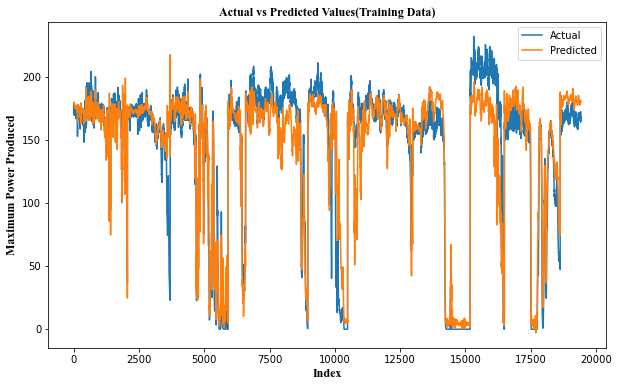

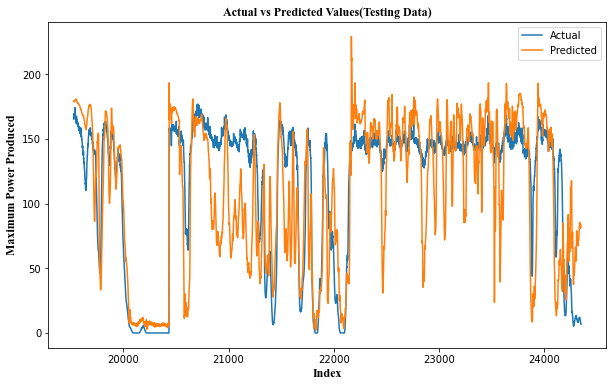

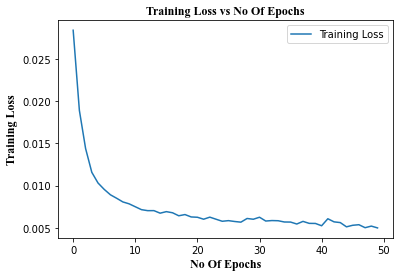

In [60]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size-time_steps], y_train_is, label='Actual')
plt.plot(df.index[:train_size-time_steps], y_train_pred, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("Index", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size+time_steps:], y_test_is, label='Actual')
plt.plot(df.index[train_size+time_steps:], y_pred, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("Index", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.title("Training Loss vs No Of Epochs" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Training Loss", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()
plt.show(model)

In [44]:
results = results.append({"Model_name":"LSTM Neural Network","RMSE": np.sqrt(mse)}, ignore_index = True)
results

,Model_name,RMSE
0,Radial Basis Function Neural Network,20.728428
1,LSTM Neural Network,28.978770


# Modular Neural Network

In [14]:
model = tf.keras.models.load_model('model_modular_1')

In [18]:



X = df.copy()[['Temperature(Â°C)', "Irradiance(W/m2)"]].values
y = df.copy()['Power(Watts)'].values

scaler_X =  MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

input_shape = (2,)

inputs = layers.Input(shape=input_shape, name="inputs")

x = layers.Dense(100, activation="relu", name="dense1")(inputs)
x = layers.Dense(64, activation="relu", name="dense2")(x)
x = layers.Dense(32, activation="relu", name="dense3")(x)


outputs = layers.Dense(1, activation="linear", name="outputs")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="modular_nn")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01), loss="mse"
)

tf.random.set_seed(20)

history = model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1, validation_data=(X_test, y_test))






Epoch 1/50
1218/1218 [==============================] - 8s 6ms/step - loss: 0.0159 - val_loss: 0.0227
Epoch 2/50
1218/1218 [==============================] - 5s 4ms/step - loss: 0.0123 - val_loss: 0.0127
Epoch 3/50
1218/1218 [==============================] - 5s 4ms/step - loss: 0.0113 - val_loss: 0.0114
Epoch 4/50
1218/1218 [==============================] - 5s 4ms/step - loss: 0.0106 - val_loss: 0.0123
Epoch 5/50
1218/1218 [==============================] - 4s 4ms/step - loss: 0.0093 - val_loss: 0.0209
Epoch 6/50
1218/1218 [==============================] - 5s 4ms/step - loss: 0.0088 - val_loss: 0.0352
Epoch 7/50
1218/1218 [==============================] - 5s 4ms/step - loss: 0.0084 - val_loss: 0.0349
Epoch 8/50
1218/1218 [==============================] - 4s 4ms/step - loss: 0.0077 - val_loss: 0.0273
Epoch 9/50
1218/1218 [==============================] - 5s 4ms/step - loss: 0.0078 - val_loss: 0.0245
Epoch 10/50
1218/1218 [==============================] - 4s 4ms/step - loss: 0.008

In [19]:
y_pred = model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred)

y_train_pred = model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred)

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')
print(f'\n')
model.summary()

609/609 [==============================] - 2s 2ms/step
Test Root Mean Squared Error: 39.5159906929
Train Root Mean Squared Error: 18.2357163276


Model: "modular_nn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 2)]               0         
                                                                 
 dense1 (Dense)              (None, 100)               300       
                                                                 
 dense2 (Dense)              (None, 64)                6464      
                                                                 
 dense3 (Dense)              (None, 32)                2080      
                                                                 
 outputs (Dense)             (None, 1)                 33        
                                                                 
Total params: 8,877
Trainable params: 8,87

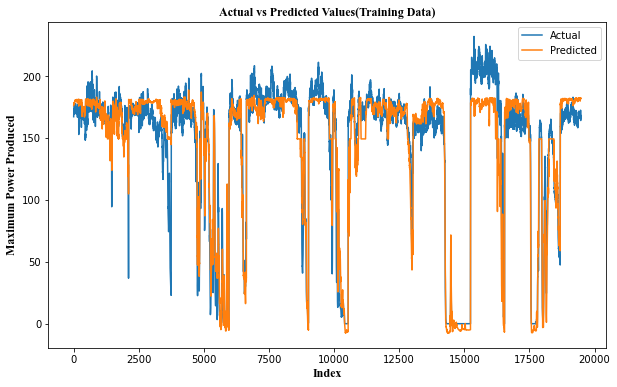

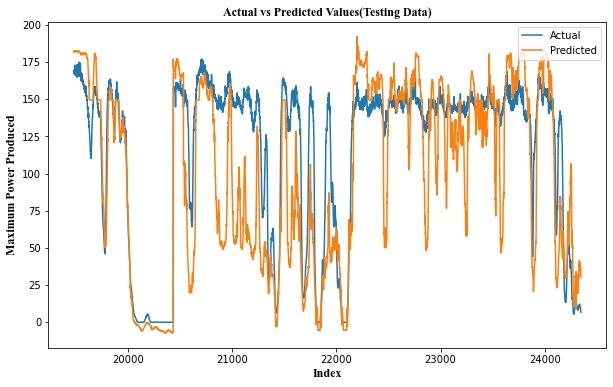

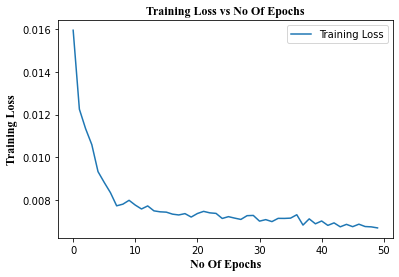

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("Index", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("Index", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()


plt.plot(history.history['loss'], label='Training Loss')
plt.title("Training Loss vs No Of Epochs" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Training Loss", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()
plt.show(model)

# Linear Regression (G and T) 

In [21]:

X = df[[ 'Irradiance(W/m2)', 'Temperature(Â°C)']].values
y = df["Power(Watts)"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]



reg_model = LinearRegression()

reg_model.fit(X_train, y_train)

y_pred = reg_model.predict(X_test)
mse_4 = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse_4:.10f}')
b0 = reg_model.intercept_[0]
b = reg_model.coef_

print("Regression equation: Y = P = {:.2f}T + {:.2f}IR - {:.2f}".format(b[0][0], b[0][1], abs(b0)))

Mean Squared Error: 0.0163547093
Regression equation: Y = P = 1.22T + -0.09IR - 0.25


In [22]:
y_pred = reg_model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred)

y_train_pred = reg_model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred)

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

Test Root Mean Squared Error: 29.7178003458
Train Root Mean Squared Error: 32.8032031082


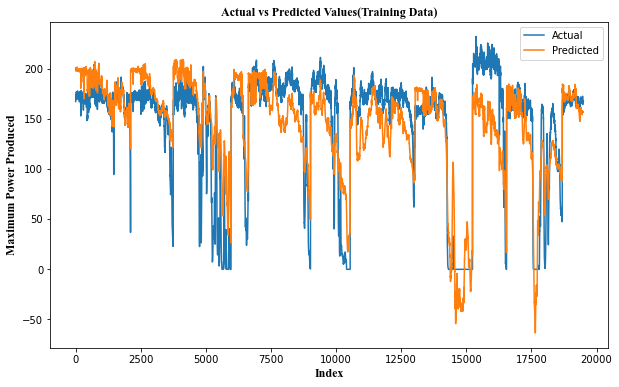

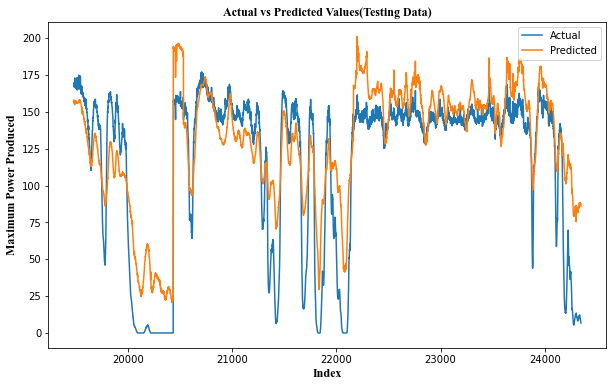

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("Index", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("Index", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

In [18]:
results = results.append({"Model_name":"Linear Regression(G and T)","MSE": mse_4}, ignore_index = True)
results

,Model_name,MSE
0,Linear Regression,0.016355


# Support Vector Machines

In [35]:
X = df[['Irradiance(W/m2)', 'Irradiance(W/m2)']].values
y = df["Power(Watts)"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]



model = SVR(kernel='rbf')

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

y_train_pred = model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1))

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

Test Root Mean Squared Error: 24.1504912637
Train Root Mean Squared Error: 26.5070617035


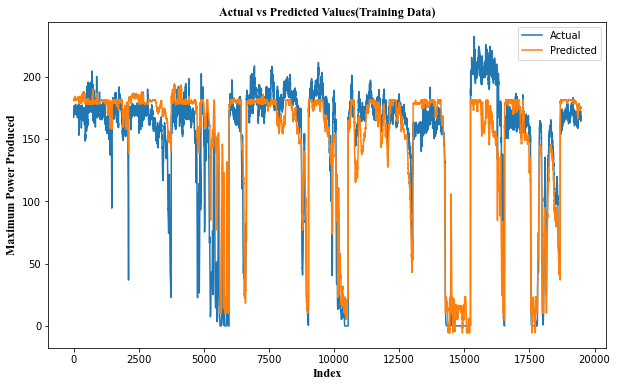

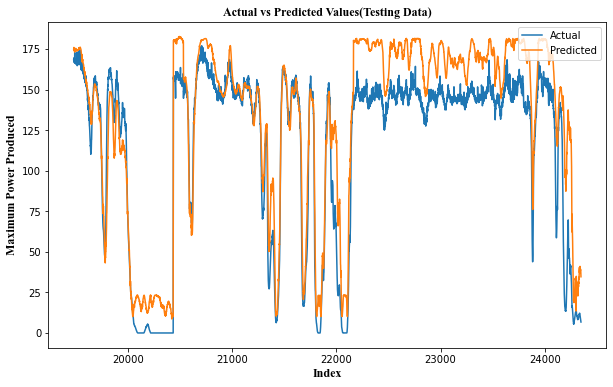

In [36]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("Index", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("Index", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

plt.show()

In [78]:
results = results.append({"Model_name":"Support Vector Machines","MSE": mse_5}, ignore_index = True)
results

,Model_name,MSE
0,Radial Basis Function Neural Network,0.007957
1,Modular Neural Network,0.006555
2,Linear Regression,0.016355
3,Support Vector Machines,0.010121


# Decision Tree Regressor

In [43]:
X = df[['Temperature(Â°C)', 'Irradiance(W/m2)']].values
y = df["Power(Watts)"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

model = DecisionTreeRegressor(max_depth= 40, min_samples_leaf=46)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse_6 = mean_squared_error(y_test, y_pred)
print("Mean squared error:", mse_6)

Mean squared error: 0.036003438315995125


In [44]:
y_pred = model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

y_train_pred = model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1))

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

Test Root Mean Squared Error: 44.0927549213
Train Root Mean Squared Error: 15.5708806018


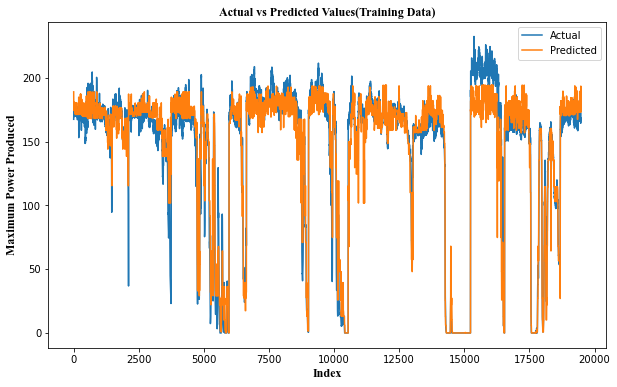

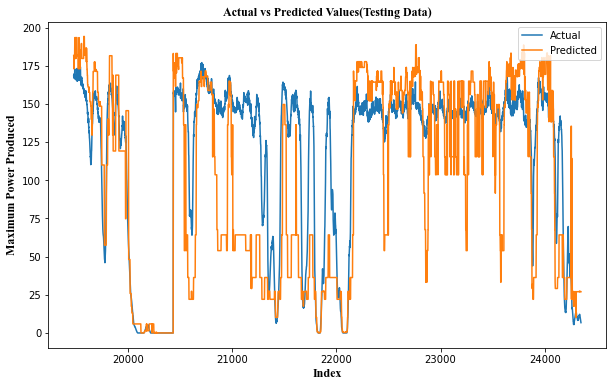

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("Index", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("Index", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

plt.show()

In [46]:
results = results.append({"Model_name":"Decision Tree Regressor","RMSE": rmse_1}, ignore_index = True)
results

,Model_name,RMSE,MSE
0,Decision Tree Regressor,NaN,0.036029


# Random forest regressor

In [46]:



X = df[['Temperature(Â°C)', 'Irradiance(W/m2)']].values
y = df["Power(Watts)"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

n_estimators = 100  # number of decision trees
model = RandomForestRegressor(n_estimators=n_estimators, max_depth= 20,
                              min_samples_leaf=5, min_samples_split=15, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

y_pred = model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

y_train_pred = model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1))

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

Test Root Mean Squared Error: 43.7432078591
Train Root Mean Squared Error: 11.5902416201


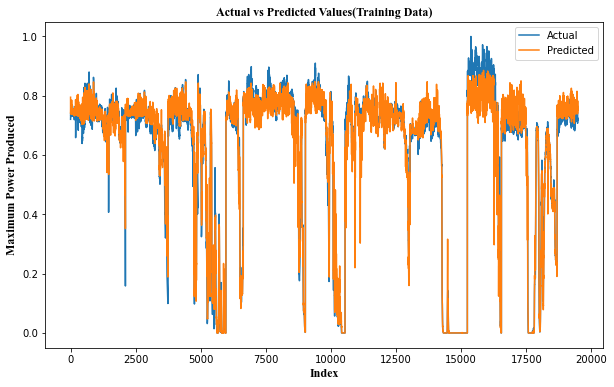

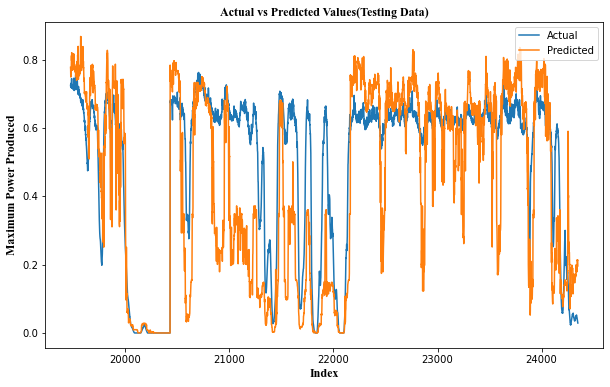

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y_train, label='Actual')
plt.plot(df.index[:train_size], y_train_pred, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("Index", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y_test, label='Actual')
plt.plot(df.index[train_size:], y_pred, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("Index", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

In [49]:
results = results.append({"Model_name":"Random forest Regressor","RMSE": rmse_1}, ignore_index = True)
results

,Model_name,RMSE,MSE
0,Decision Tree Regressor,NaN,0.036029
1,Random forest Regressor,44.686414,NaN


# Orthogonal linear regression

In [48]:
X = df.copy()[['Temperature(Â°C)', "Irradiance(W/m2)"]].values
y = df.copy()['Power(Watts)'].values

scaler_X =  MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

model = OrthogonalMatchingPursuit()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

b0 = model.intercept_[0]
b = model.coef_

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Regression equation: Y = P = {:.2f}T + {:.2f}IR^2 - {:.2f}".format(b[0], b[1], abs(b0)))

Regression equation: Y = P = 0.00T + 1.16IR^2 - 0.25


In [49]:
y_pred = model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

y_train_pred = model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1))

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')

results = results.append({"Model_name":"Orthogonal linear regression","RMSE": rmse_1}, ignore_index = True)
results

Test Root Mean Squared Error: 29.4884552431


,Model_name,RMSE
0,Linear regression(G^2 and T),29.923490
1,Linear regression(G^2 and T^2),29.813478
2,Linear regression(G and T^2),29.873945
3,Orthogonal linear regression,29.488455


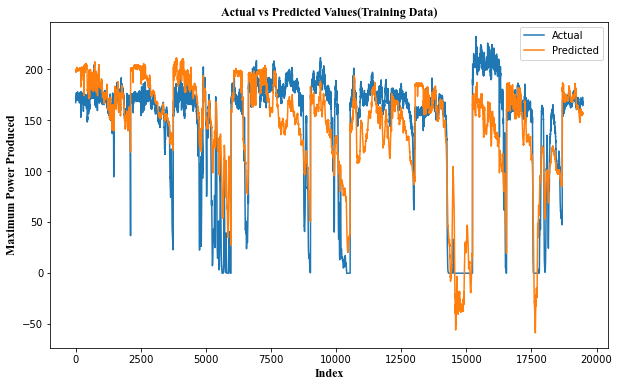

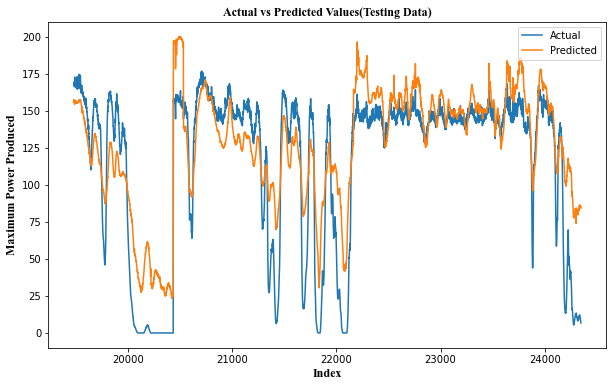

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("Index", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("Index", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

# Quantile Linear regression

In [51]:
import numpy as np
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

X = df.copy()[['Temperature(Â°C)', "Irradiance(W/m2)"]].values
y = df.copy()['Power(Watts)'].values

scaler_X =  MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]


quantile_model = sm.QuantReg(y_train, X_train)
quantile_result = quantile_model.fit(q=0.2)  # Change the quantile value as needed

predicted_power = quantile_result.predict(X)



In [52]:
y_pred = quantile_result.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

y_train_pred = quantile_result.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1))

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

Test Root Mean Squared Error: 34.4555112436
Train Root Mean Squared Error: 37.2945797403


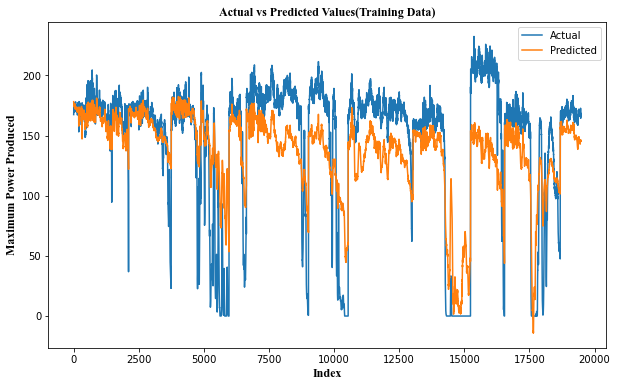

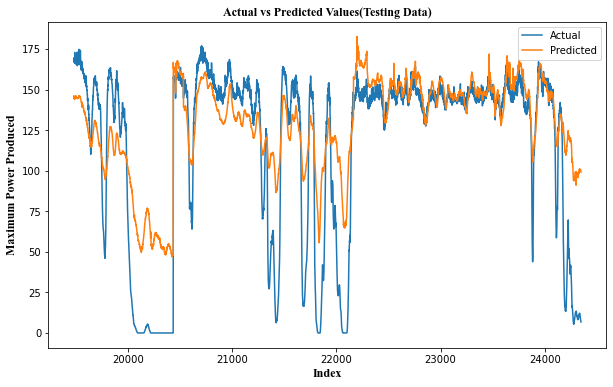

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("Index", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("Index", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

# Linear Regression(G^2 and T)

In [24]:
X = df[['Temperature(Â°C)', 'Irradiance(W/m2)']]
X["Irradiance(W/m2)"] = X["Irradiance(W/m2)"]**2
X = X.values
y = df["Power(Watts)"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]



reg_model = LinearRegression()

reg_model.fit(X_train, y_train)

y_pred = reg_model.predict(X_test)
mse_4 = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse_4:.10f}')
b0 = reg_model.intercept_[0]
b = reg_model.coef_

print("Regression equation: Y = P = {:.2f}T + {:.2f}IR^2 - {:.2f}".format(b[0][0], b[0][1], abs(b0)))

Mean Squared Error: 0.0165818890
Regression equation: Y = P = -0.17T + 1.03IR^2 - 0.07


In [25]:
y_pred = reg_model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred)

y_train_pred = reg_model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred)

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

results = results.append({"Model_name":"Linear regression(G^2 and T)","RMSE": rmse_1}, ignore_index = True)
results

Test Root Mean Squared Error: 29.9234902607
Train Root Mean Squared Error: 34.9592949571


,Model_name,RMSE
0,Linear regression(G^2 and T),29.92349


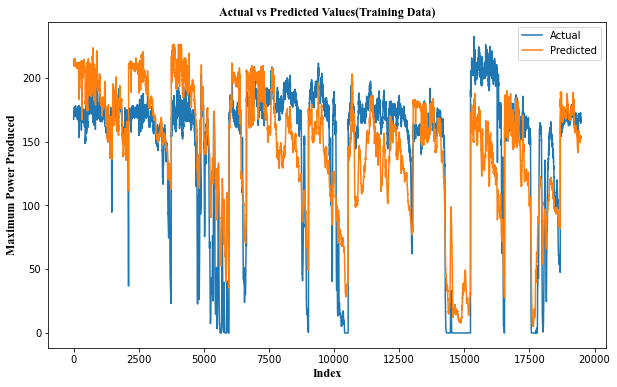

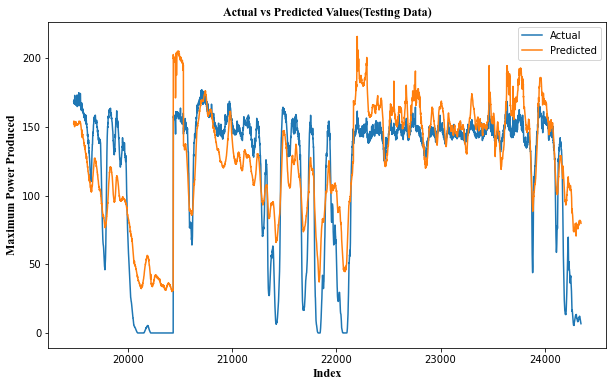

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("Index", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("Index", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

# Linear Regression(G^2 and T^2)

In [27]:
X = df[['Temperature(Â°C)', 'Irradiance(W/m2)']]
X["Temperature(Â°C)"] = X["Temperature(Â°C)"]**2
X["Irradiance(W/m2)"] = X["Irradiance(W/m2)"]**2
X = X.values
y = df["Power(Watts)"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]



reg_model = LinearRegression()

reg_model.fit(X_train, y_train)

y_pred = reg_model.predict(X_test)
mse_4 = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse_4:.10f}')
b0 = reg_model.intercept_[0]
b = reg_model.coef_

print("Regression equation: Y = P = {:.2f}T + {:.2f}IR^2 - {:.2f}".format(b[0][0], b[0][1], abs(b0)))

Mean Squared Error: 0.0164601879
Regression equation: Y = P = -0.24T + 1.09IR^2 - 0.02


In [28]:
y_pred = reg_model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred)

y_train_pred = reg_model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred)

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

results = results.append({"Model_name":"Linear regression(G^2 and T^2)","RMSE": rmse_1}, ignore_index = True)
results

Test Root Mean Squared Error: 29.8134777844
Train Root Mean Squared Error: 34.4184101459


,Model_name,RMSE
0,Linear regression(G^2 and T),29.923490
1,Linear regression(G^2 and T^2),29.813478


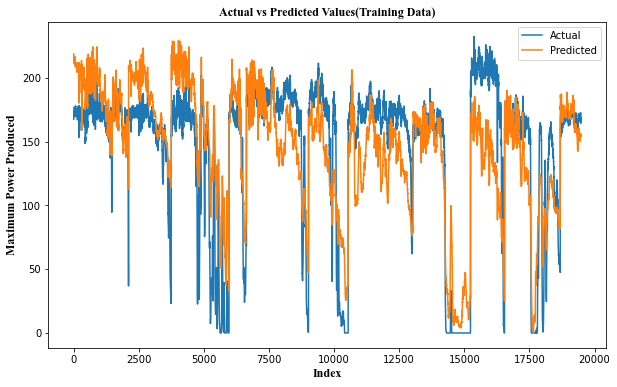

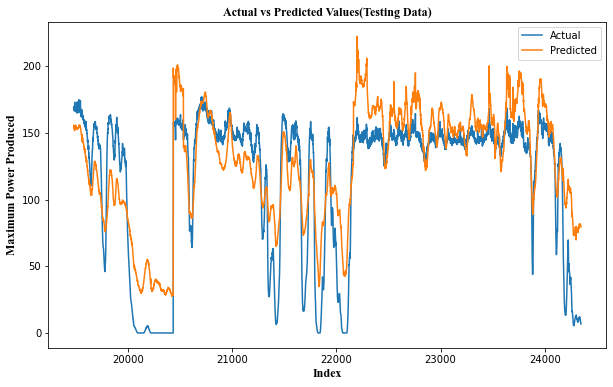

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("Index", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("Index", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

# Linear Regression(G and T^2)

In [31]:
X = df[['Temperature(Â°C)', 'Irradiance(W/m2)']]
X["Temperature(Â°C)"] = X["Temperature(Â°C)"]**2
X = X.values
y = df["Power(Watts)"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]



reg_model = LinearRegression()

reg_model.fit(X_train, y_train)

y_pred = reg_model.predict(X_test)
mse_4 = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse_4:.10f}')
b0 = reg_model.intercept_[0]
b = reg_model.coef_

print("Regression equation: Y = P = {:.2f}T^2 + {:.2f}IR - {:.2f}".format(b[0][0], b[0][1], abs(b0)))

Mean Squared Error: 0.0165270244
Regression equation: Y = P = -0.13T^2 + 1.25IR - 0.28


In [32]:
y_pred = reg_model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred)

y_train_pred = reg_model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred)

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

results = results.append({"Model_name":"Linear regression(G and T^2)", "RMSE": rmse_1}, ignore_index = True)
results

Test Root Mean Squared Error: 29.8739451597
Train Root Mean Squared Error: 32.6068244393


,Model_name,RMSE
0,Linear regression(G^2 and T),29.923490
1,Linear regression(G^2 and T^2),29.813478
2,Linear regression(G and T^2),29.873945


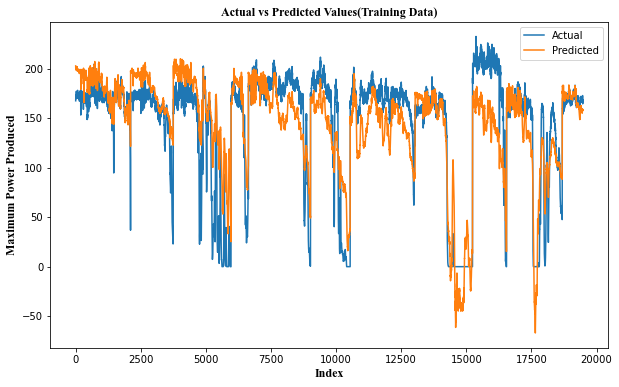

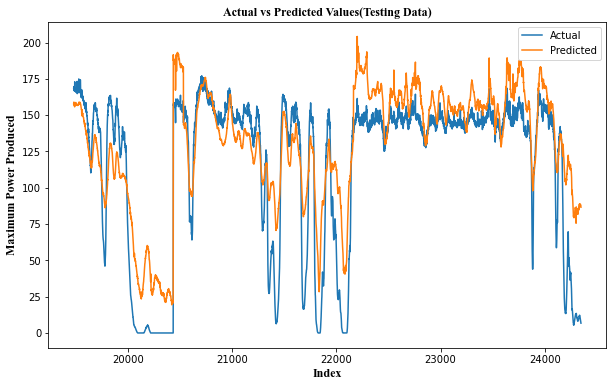

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("Index", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("Index", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

# Ridge Regression

In [54]:

X = df[[ 'Irradiance(W/m2)', 'Temperature(Â°C)']].values
y = df["Power(Watts)"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]



reg_model = Ridge(alpha=0.3)

reg_model.fit(X_train, y_train)

y_pred = reg_model.predict(X_test)
mse_4 = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse_4:.10f}')
b0 = reg_model.intercept_[0]
b = reg_model.coef_

y_pred = reg_model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

y_train_pred = reg_model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1))

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

Mean Squared Error: 0.0163599743
Test Root Mean Squared Error: 29.7225834049
Train Root Mean Squared Error: 32.8032243464


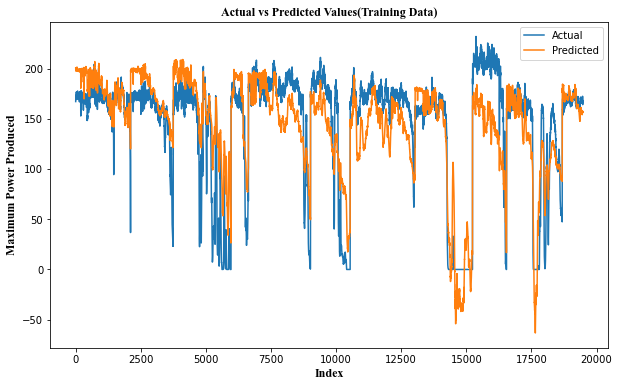

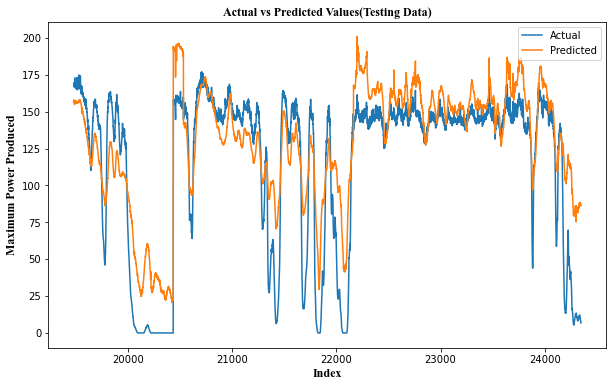

In [55]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("Index", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("Index", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

# Kernel Ridge Regression

In [56]:
from sklearn.kernel_ridge import KernelRidge

X = df[[ 'Irradiance(W/m2)', 'Temperature(Â°C)']].values
y = df["Power(Watts)"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]



reg_model = KernelRidge(kernel='rbf', alpha=0.1)

reg_model.fit(X_train, y_train)

y_pred = reg_model.predict(X_test)
mse_4 = mean_squared_error(y_test, y_pred)


y_pred = reg_model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

y_train_pred = reg_model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1))

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

Test Root Mean Squared Error: 21.8488384297
Train Root Mean Squared Error: 26.5787088926


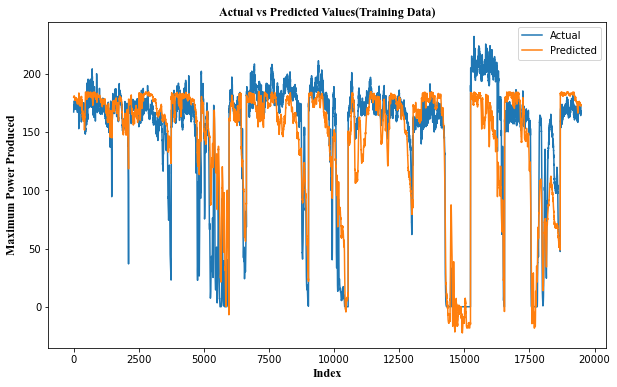

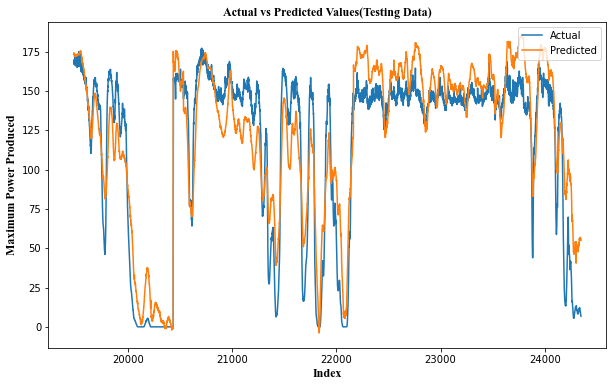

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("Index", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("Index", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()